In [1]:
%matplotlib inline
import math
import time 
import numpy as np
import torch as t
import matplotlib.pyplot as plt



In [2]:
## aside: vectorization is faster! 

n = 1000
a = t.ones(n)
b = t.ones(n)
c = t.zeros(n)
t_0 = time.time()
for i in range(n):
    c[i] = a[i] + b[i]
print(f"{time.time() - t_0} sec")

t_0 = time.time()
d = a + b
print(f"{time.time() - t_0} sec")
## not as big of a difference on my computer... 1 order of magnitude instead of 3

0.008521795272827148 sec
0.00024509429931640625 sec


Building a simple MNIST classifier

In [3]:
## Load the dataset
from torchvision import transforms 
import torchvision

trans = []
trans.append(transforms.ToTensor())
print(trans)
trans = transforms.Compose(trans)
print(trans)

train = torchvision.datasets.FashionMNIST(root = "../data", transform = trans, train = True, download = True)
test = torchvision.datasets.FashionMNIST(root = "../data", transform = trans, train = False, download = True)


[ToTensor()]
Compose(
    ToTensor()
)


Start with a toy example: Take just two categories
 Make a crude estimate using a hyperplane decision boundary between their means! (Take the vector between their means !) 

In [30]:
### separate into categories 0 and 1 based on label 

X_train_0 = t.stack([x[0] for x in train if x[1] == 0]).type(t.float32)
X_train_1 = t.stack([x[0] for x in train if x[1] == 1]).type(t.float32)
X_test = t.stack([x[0] for x in test if x[1]==0 or x[1]==1]).type(t.float32)
y_test = t.stack([t.tensor(x[1]) for x in test if x[1]==0 or x[1]==1]).type(t.float32)
print(X_train_0.shape, X_train_1.shape, X_test.shape, y_test.shape)

## compute means of each dataset over all training examples

ave_0 = t.mean(X_train_0, axis = 0)
ave_1 = t.mean(X_train_1, axis = 0)

torch.Size([6000, 1, 28, 28]) torch.Size([6000, 1, 28, 28]) torch.Size([2000, 1, 28, 28]) torch.Size([2000])


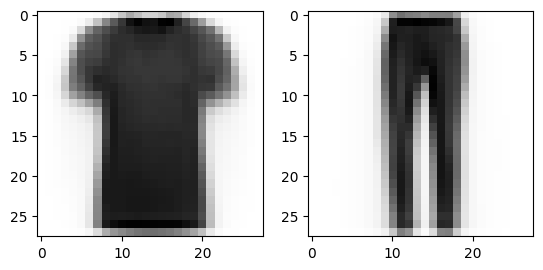

In [5]:
_, axes = plt.subplots(1,2)
## shirts 
axes[0].imshow(ave_0.reshape(28,28).tolist(), cmap = 'Greys')
## pants 
axes[1].imshow(ave_1.reshape(28,28).tolist(), cmap = 'Greys')


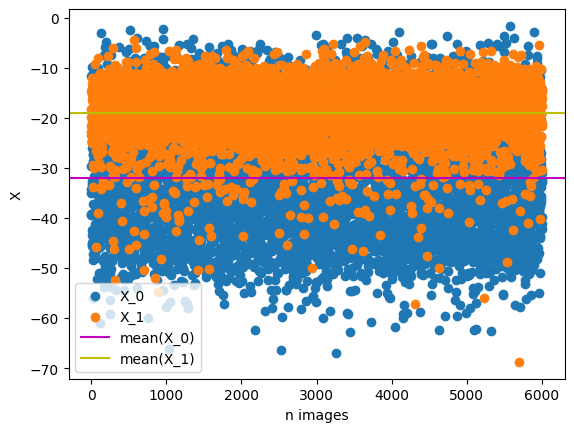

In [69]:
#### Instead of learning the boundary, take the difference between their means as the discriminant vector
##
w = (ave_1 - ave_0).T

dummy = t.arange(X_train_0.shape[0])
#plt.scatter(dummy, weighted)
X_0_disc = X_train_0.reshape(X_train_0.shape[0], -1) @ w.flatten()
X_1_disc = X_train_1.reshape(X_train_1.shape[0], -1) @ w.flatten()
assert X_0_disc.shape == X_1_disc.shape

plt.scatter(dummy, X_0_disc)
plt.scatter(dummy, X_1_disc)
plt.axhline(y=X_0_disc.mean().item(), color = 'm')
plt.axhline(y=X_1_disc.mean().item(), color = 'y')
plt.xlabel("n images")
plt.ylabel("X")
plt.legend(["X_0", "X_1","mean(X_0)","mean(X_1)"])
# The first category especially seems to have a large spread, but the decision boundary seems to be around -25


In [61]:
X_1_disc.mean()

tensor(-19.0351)

In [37]:
## What is the accuracy on the test set? 
thresh = -25

y_0 = t.zeros(len(X_0_disc))

y_1 = t.ones(len(X_0_disc))
print(len(y_0))
## Not very good at classifying class 0 (from the plot, this makes sense (and is a little confusing))
acc_0 = t.mean(((X_0_disc < thresh).type(y_test.dtype) == y_0).float(), dtype = t.float32)
print(f"Accuracy_0 =  {acc_0}")
## Much better at classifying class 1
acc_1 = t.mean(((X_1_disc > thresh).type(y_test.dtype) == y_1).float(), dtype = t.float32)
print(f"Accuracy_1 = {acc_1}")

6000
Accuracy_0 =  0.29600000381469727
Accuracy_1 = 0.903333306312561


threshold = -25, max accuracy = 0.8119999766349792


Text(0, 0.5, 'Accuracy')

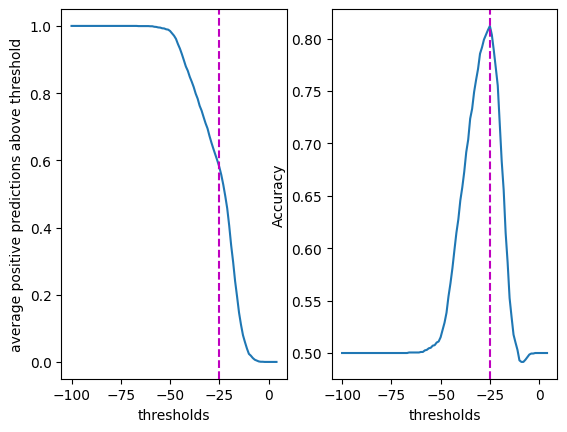

In [38]:
### Let's try it systematically on the test set for a few values of the threshold
thresholds = t.arange(-100,5,1)

preds_list = [(X_test.reshape(2000, -1) @ w.flatten()  > thresh).type(y_test.dtype) for thresh in thresholds]
## average number of predictions above the threshold
preds_mean = [t.mean(preds) for preds in preds_list]
## accuracy 
acc_list = [t.mean((preds == y_test).float(), dtype = t.float32) for preds in preds_list]
max_pos = t.argmax(t.tensor(acc_list))

print(f"threshold = {thresholds[max_pos.item()]}, max accuracy = {acc_list[max_pos.item()]}")

_, ax = plt.subplots(1,2)
ax[0].plot(thresholds, preds_mean)
ax[0].axvline(x=-25,color = "m",ls = "--")
ax[0].set_xlabel("thresholds")
# should be roughly half for a balanced dataset 
ax[0].set_ylabel("average positive predictions above threshold")
ax[1].plot(thresholds, acc_list)
ax[1].axvline(x=-25,color = 'm',ls = "--")
ax[1].set_xlabel("thresholds")
ax[1].set_ylabel("Accuracy")




As a second warm-up, let's design another decision plane based on the dot product of the two average vectors

In [50]:
#### Try using PCA to simplify things a bit 
### PCA : re-express a high-dim dataset (features) in terms of a lower dimensional dataset with minimal information loss

# #As an example, consider 2d data 
# X = t.tensor([[.3,.5],[.4,.3],[.7,.4],[.5,.7],[.3,.2],[.9,.8],[.1,.2],[.2,.5],[.6,.9],[.2,.2],[.6,.8],[.4,.6],[.3,.4],[.6,.5],[.8,.5],[.8,.9],[.2,.3],[.7,.7],[.5,.5],[.6,.4]])
# # subtract the mean to normalize it 
# print(X.mean(axis=0),len(X))
# X_0 = X - X.mean()
# assert X_0.mean() == 0
# ## should be centered around 0 
# plt.scatter(X[:,0],X[:,1])
# plt.scatter(X_0[:,0],X_0[:,1])
# plt.xlabel('x1')
# plt.ylabel('x2')
# plt.legend(["un-normalized","normalized"])

#normalize the data 
X_0_norm = X_train_0 - ave_0
X_1_norm = X_train_1 - ave_1
assert X_0_norm.shape == X_train_0.shape

t.norm(X_0_norm, dim = -1).shape

torch.Size([6000, 1, 28])

In [71]:
X_train_0

tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],


        [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],


        [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..